# Baseline Model

In [121]:
## Baseline Model
## Feature Eng: N/A
## Purpose: To create a baseline model in which we will compare all other models.
## Results : 
##      LightGBM Model RMSE is:  41.832205150844366
##      LightGBM Model R2 Score is:  0.041876326312617396
##      LightGBM Model Cross-validation MAE is: 23.686721000105056
##      XGBoostModel RMSE is:  42.49159235245101
##      XGBoost Model R2 Score is:  0.011433096664787312
##      XGBoost Model Cross-validation MAE is:  22.613395

In [122]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [123]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/Regression_no_outliers_cleaned_data_03.csv', sep = ',')

In [124]:
df_flight_info = data_flight_info.copy()
df_flight_info.isnull().sum()

fl_date                0
mkt_unique_carrier     0
op_unique_carrier      0
op_carrier_fl_num      0
origin                 0
crs_dep_time           0
dep_time               0
dep_delay              0
dest                   0
arr_time               0
arr_delay              0
crs_arr_time           0
crs_elapsed_time       0
actual_elapsed_time    0
distance               0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
year                   0
month                  0
day                    0
weekday                0
dtype: int64

In [125]:
#Only want top 19 busiest airports
airports = ['ORD','ATL','DFW','DEN','LAX','CLT','SEA','SFO','EWR','LGA','PHX','IAH','LAS','BOS','MCO','DTW','PHIL','DCA','MSP']
df_flight_info = df_flight_info[df_flight_info['origin'].isin(airports)]
df_flight_info.origin.value_counts()

ATL    48923
ORD    48428
DFW    35688
DEN    33907
LAX    30969
CLT    30851
SEA    23313
PHX    22252
SFO    22183
IAH    22017
DTW    21795
LAS    20661
LGA    20597
MSP    19965
EWR    19453
BOS    18365
MCO    17474
DCA    17438
Name: origin, dtype: int64

In [126]:
# Getting Average Carrier Delay - Grouped by Carrier
carrier_grouped = df_flight_info.groupby(by='op_unique_carrier').mean()
carrier_grouped.reset_index(inplace=True)
carrier_grouped['total_carrier_delay'] = carrier_grouped['carrier_delay'] + carrier_grouped['late_aircraft_delay']
carrier_grouped = carrier_grouped[['op_unique_carrier', 'total_carrier_delay']]
df_flight_info = df_flight_info.drop(['carrier_delay','late_aircraft_delay'],axis=1) 

# Model Training

In [127]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Feature Engineered Dataset

####  with Flight Number (onehot), average_route_time, total_security_delay, total_nas_delay

In [128]:
#### Shuffling dataset so model doesn't train on pattern

In [129]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','crs_elapsed_time','crs_arr_time','distance','year','month','day','weekday']]
y = df_flight_info['arr_delay']

In [130]:
X.shape

(474279, 8)

In [131]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [132]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.08
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 5
params['max_depth'] = 100
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 331995, number of used features: 8
[LightGBM] [Info] Start training from score 5.782494
Model RMSE is:  42.20535047986747
Model R2 Score is:  0.039697491421151754


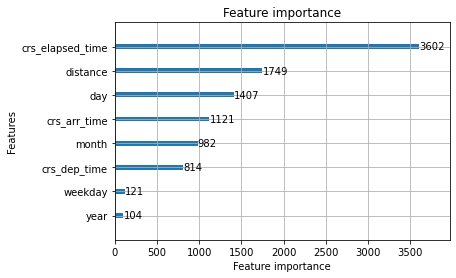

In [133]:
#Examine the importance of each feature column in the original data set with the model
lgb.plot_importance(reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [134]:
# Cross-validate
cv_results = lgb.cv(
        params,
        d_train,
        num_boost_round=100,
        nfold=3,
        metrics='mae',
        early_stopping_rounds=10,

        stratified=False
        )
# Display results
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['l1-mean']))
print('LightGBM Model Cross-validation MAE is:', cv_results['l1-mean'][-1])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 221330, number of used features: 8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 221330, number of used features: 8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number 

##### XGBoost

In [135]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  42.791967404126474
Model R2 Score is:  0.012817269410352772


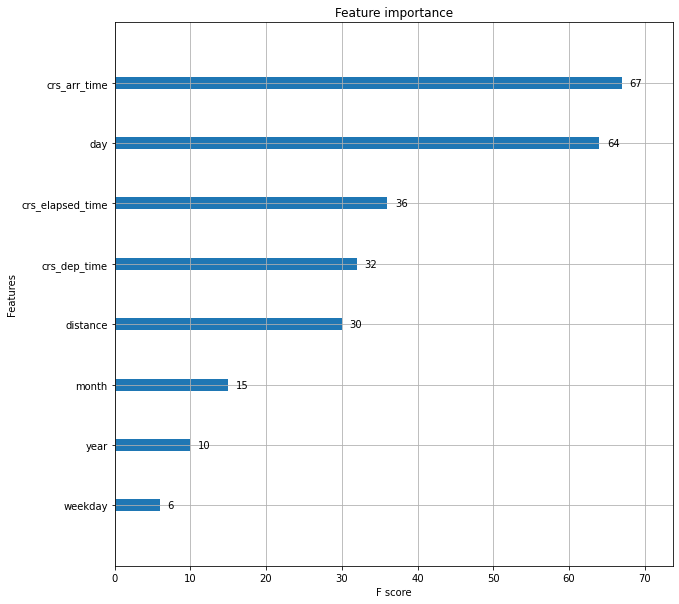

In [136]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

In [137]:
params = {'objective':'reg:squarederror', 'colsample_bytree' : 0.3, 'learning_rate' : 0.1,
                'max_depth' : 5, 'alpha' : 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="mae", as_pandas=True, seed=123)

print('XGBoost Model Cross-validation MAE is: ',(cv_results["test-mae-mean"]).tail(1))

XGBoost Model Cross-validation MAE is:  0    22.631131
Name: test-mae-mean, dtype: float64


##### Linear Regression

In [138]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# creating linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_lr = lr.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_lr)))
print('Model R2 Score is: ',r2_score(y_test,y_lr))

Model RMSE is:  43.04104288924509
Model R2 Score is:  0.013131517320775776


In [139]:
from numpy import mean
from numpy import absolute

#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
model = lr

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Linear Model Cross-validation MAE is: ',mean(absolute(scores)))

Linear Model Cross-validation MAE is:  24.118240514315723


##### Ridge/Lasso Regression

In [140]:
ridgereg = Ridge(alpha=0.001,normalize=True)
ridge = ridgereg.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_ridge))

lassoreg = Lasso(alpha=0.001,normalize=True)
lasso = lassoreg.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_lasso))

Model RMSE is:  43.041070309365246
Model R2 Score is:  0.013130259913465281
Model RMSE is:  43.05590120040171
Model R2 Score is:  0.01245004080615153


In [141]:
#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple ridge regression model
model = ridgereg

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Ridge Model Cross-validation MAE is: ',mean(absolute(scores)))

#build multiple lassp regression model
model = lassoreg

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Lasso Model Cross-validation MAE is: ',mean(absolute(scores)))

Ridge Model Cross-validation MAE is:  24.118068495470478
Lasso Model Cross-validation MAE is:  24.101220008467802


##### Random Forest

In [142]:
#Create a Gaussian Regressor
clf=RandomForestRegressor(n_estimators=100)

In [143]:
#Train the model using the training sets 
clf.fit(X_train,y_train)

RandomForestRegressor()

In [144]:
y_pred=clf.predict(X_test)

In [145]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))

Model RMSE is:  43.83840496678188
Model R2 Score is:  -0.023771878946835523


In [146]:
#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple ridge regression model
model = clf

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Random Forest Model Cross-validation MAE is: ',mean(absolute(scores)))

Random Forest Model Cross-validation MAE is:  25.57832227468334
